# Face-antispoofing using mobilenet_v2

### If you are going to read this notebook, I recommend you to open it in [google colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true) and start reading from [the beginning of the analysis](#scrollTo=IYKr7zY7CyWb), using the attached hyperlinks on functions and classes if you need to.

## Required libraries and defined functions:

In [ ]:
pip install facenet-pytorch

In [2]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive, files

import os
import shutil

from skimage import io, color

import re

import collections

import numpy as np
import pandas as pd 

import zipfile
from sklearn.metrics import f1_score
import copy
import traceback
import datetime
import random

from facenet_pytorch import MTCNN, InceptionResnetV1

from tqdm.notebook import tqdm

from operator import getitem

from math import ceil

from PIL import Image
import pylab
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder

In [3]:
def clear_dir(dir_path):
    for root, dirs, files in os.walk(dir_path):
        for f in files:
            os.unlink(os.path.join(root, f))
        for d in dirs:
            shutil.rmtree(os.path.join(root, d))

In [4]:
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

init_random_seed()

In [5]:
def show_image(path, title=''):
    plt.imshow(Image.open(path))
    plt.title(title)
    plt.show()

In [6]:
def show_images(paths, subtitle, size, columns = 3):
    rows = ceil(len(paths) / columns)
    fig = pylab.figure(figsize=size)
    fig.suptitle(subtitle)
    for i in range(len(paths)):
        fig.add_subplot(rows, columns, i + 1)
        img = Image.open(paths[i])
        pylab.imshow(img)
        pylab.axis('off')
    pylab.show()

In [7]:
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Invalid data type {}'.format(type(data)))

In [8]:
def train_eval_loop(model, train_dataset, val_dataset, criterion,
                    lr=1e-4, epoch_n=10, batch_size_train=32, batch_size_val=32,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0):
    """
    Loop for model training. After each epoch, the quality of the model is assessed by validation sampling.
    :param model: torch.nn.Module - training model
    :param train_dataset: torch.utils.data.Dataset - train data
    :param val_dataset: torch.utils.data.Dataset - validation data
    :param criterion: loss function
    :param lr: learning rate
    :param epoch_n: maximum number of epochs
    :param batch_size_train: number of examples processed by the model per iteration for train
    :param batch_size_val: number of examples processed by the model per iteration for validation
    :param device: cuda/cpu - device for calculations
    :param early_stopping_patience: maximum number of epochs no model improvement is allowed to continue learning
    :param l2_reg_alpha: L2-regularization coefficient
    :param max_batches_per_epoch_train: maximum number of iterations per training epoch
    :param max_batches_per_epoch_val: maximum number of iterations per validation epoch
    :param data_loader_ctor: function for creating an object that converts a dataset into batches
        (torch.utils.data.DataLoader as dafault)
    :return: a tuple of two elements:
         - the average value of the validation loss function at the best epoch
         - the best model
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size_train, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size_val, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            print('Epoch {}'.format(epoch_i))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n
            print('{} iterations, {:0.2f} sec'.format(train_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Average value of the train loss function:', mean_train_loss)


            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            print('Average value of the validation loss function:', mean_val_loss)

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('New best model!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('The model has not improved over the last {} epochs, stop training'.format(
                    early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step()

            print()
        except KeyboardInterrupt:
            print('Stopped early by user')
            break
        except Exception as ex:
            print('Error while training: {}\n{}'.format(ex, traceback.format_exc()))
            break

    return best_val_loss, best_model

In [9]:
def predict_with_model(model, dataset, device=None, batch_size=32, num_workers=0, return_labels=False):
    """
    :param model: torch.nn.Module - trained model
    :param dataset: torch.utils.data.Dataset - data for applying the model
    :param device: cuda/cpu - device for calculationg
    :param batch_size: number of examples processed by the model per iteration
    :return: numpy.array with dimension = len(dataset)
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results_by_batch = []

    device = torch.device(device)
    model.to(device)
    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    labels = []
    with torch.no_grad():
        for batch_x, batch_y in tqdm(dataloader, total=len(dataset)/batch_size):
            batch_x = copy_data_to_device(batch_x, device)

            if return_labels:
                labels.append(batch_y.numpy())

            batch_pred = model(batch_x)
            results_by_batch.append(batch_pred.detach().cpu().numpy())

    if return_labels:
        return np.concatenate(results_by_batch, 0), np.concatenate(labels, 0)
    else:
        return np.concatenate(results_by_batch, 0)

___
# Facial real/spoof classification
### Data loading:

In [10]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
clear_dir('/tmp')

local_zip = '/content/gdrive/My Drive/ML/datasets/Face_antispoofing_data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/Face_antispoofing_data')
zip_ref.close()

### Using MTCNN to crop faces:

In [14]:
mtcnn = MTCNN(select_largest=False, image_size = 224, post_process=False, device='cuda:0')
from_dir = '/tmp/Face_antispoofing_data'
dest_dir = '/tmp/Face_antispoofing_data_cropped'
dirs = ["train/real", "train/spoof", "test/unknown"]

for dir in dirs:
    os.makedirs(os.path.join(dest_dir, dir), exist_ok=True)

In [15]:
wrong_paths = [[], [], []]
for i, dir in enumerate(dirs):
    for filename in tqdm(os.listdir(os.path.join(from_dir, dir))):
        try:
            mtcnn(Image.open(os.path.join(from_dir, dir, filename)), save_path = os.path.join(dest_dir, dir, filename))
        except:
            wrong_paths[i].append(os.path.join(from_dir, dir, filename))            
            if dir == "test/unknown":
                shutil.copy(os.path.join(from_dir, dir, filename), os.path.join(dest_dir, dir, filename))         

 ### Convertation in LAB colors (not improved the result):

In [ ]:
# for dir in dirs:
#     for filename in tqdm(os.listdir(os.path.join(dest_dir, dir))):
#         img = Image.open(os.path.join(dest_dir, dir, filename))
#         img = color.rgb2lab(img)
#         data = np.asarray(img, dtype="int32")
#         img = Image.fromarray((data * 255).astype(np.uint8))
#         img.save(os.path.join(dest_dir, dir, filename))

### Look at bad photos:

In [16]:
print("bad train real photos:", len(wrong_paths[0]))
print("bad train spoof photos:", len(wrong_paths[1]))
print("bad test photos:", len(wrong_paths[2]))

bad train real photos: 4
bad train spoof photos: 72
bad test photos: 17


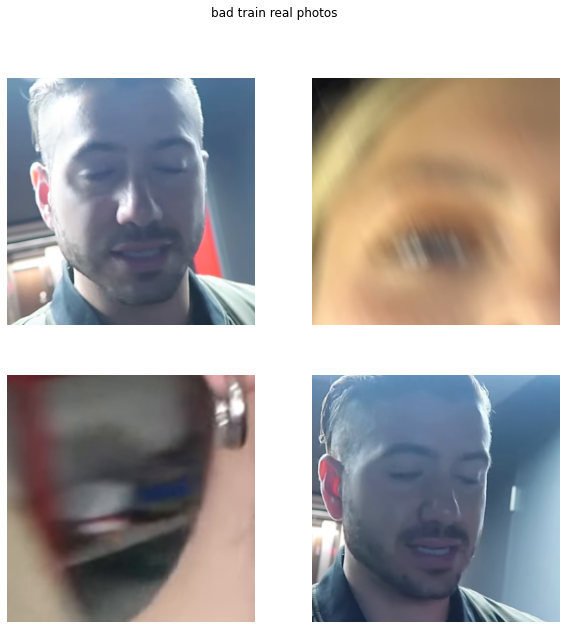

In [17]:
show_images(wrong_paths[0], "bad train real photos", size = (10, 10), columns = 2)

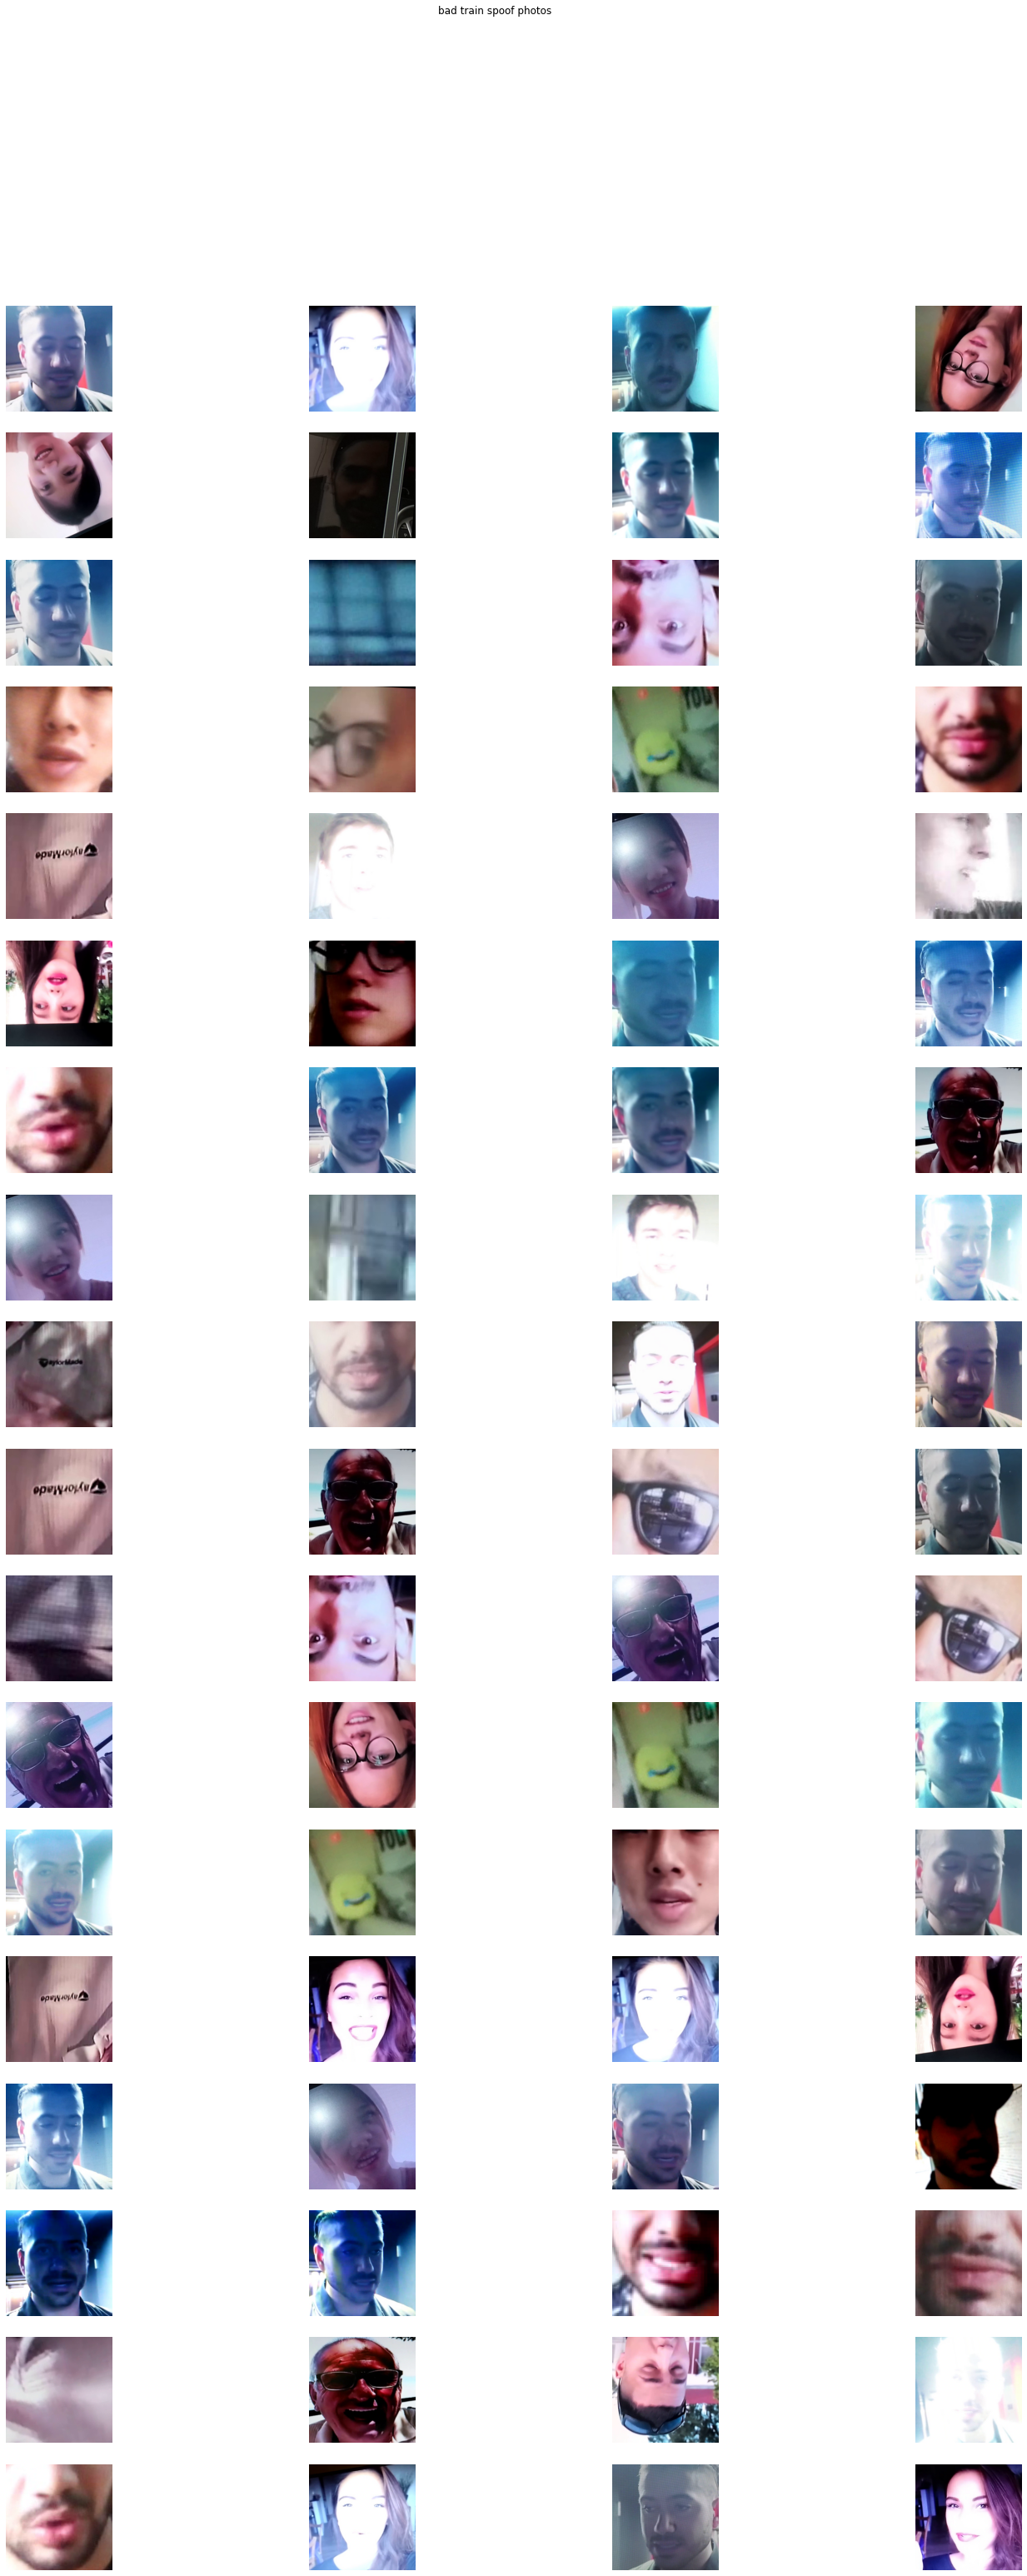

In [18]:
show_images(wrong_paths[1], "bad train spoof photos", size = (25, 50), columns = 4)

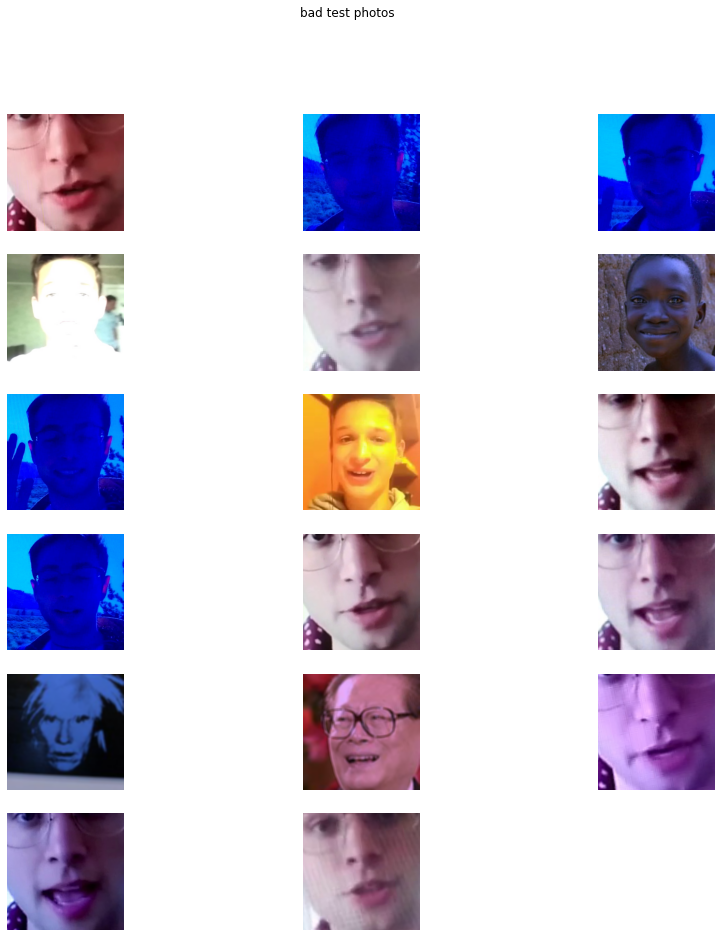

In [19]:
show_images(wrong_paths[2], "bad test photos", size = (15, 15), columns = 3)

### Creating a validation dataset by several ids:

In [20]:
base_dir = '/tmp/Face_antispoofing_data_cropped'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

class_names = ['real', 'spoof']

In [21]:
for class_name in class_names:
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

### Look at amount of real/spoof photos for every id to find ids appropriate for validation:

In [22]:
check_ids = []
imgs_to_remove = []
for i in range(200):
    check_ids.append(str(i))

check_dict = collections.defaultdict(lambda: collections.defaultdict(int)) # dict of dicts with int values

for class_name in class_names:
    source_dir = os.path.join(train_dir, class_name)
    for id in check_ids:
        paths = [f for f in os.listdir(source_dir) if re.search('_id' + id + '_', f)]
        class_count = len(paths)
        if class_count > 200:
            imgs_to_remove += list(np.random.choice(np.asarray(paths), class_count - 200, replace = False))
            class_count = 200    
        check_dict[id][class_name] = class_count

In [23]:
for p in imgs_to_remove:
    os.remove(os.path.join(base_dir, "train", "spoof", p))

In [ ]:
for s in sorted(check_dict.items(), key=lambda x: abs(getitem(x[1],'real') - getitem(x[1],'spoof'))):
    if (getitem(s[1], 'spoof') != 0 and getitem(s[1], 'real') != 0):
        print(s)

In [ ]:
val_ids = [] # ids for validation
val_s = 0
i = 0
check_dict_sorted = sorted(check_dict.items(), key=lambda x: abs(getitem(x[1],'real') - getitem(x[1],'spoof')))
while val_s <= 1000:
    if check_dict_sorted[i][1]['spoof'] != 0 and check_dict_sorted[i][1]['real'] != 0:
        val_ids.append("_id" + str(check_dict_sorted[i][0]) + "_")
        val_s += check_dict_sorted[i][1]['spoof'] + check_dict_sorted[i][1]['real']
    i += 1

print(val_ids) 

In [26]:
regexp = re.compile("(" + "|".join(val_ids) + ")")

for class_name in class_names:
    source_dir = os.path.join(train_dir, class_name)
    for file_name in tqdm(os.listdir(source_dir)):
        if regexp.search(file_name):
            shutil.move(os.path.join(source_dir, file_name), os.path.join(val_dir, class_name, file_name))

In [27]:
print('total training real photos:', len(os.listdir(os.path.join(train_dir, class_names[0]))))
print('total training spoof photos:', len(os.listdir(os.path.join(train_dir, class_names[1]))))
print('total validation real photos:', len(os.listdir(os.path.join(val_dir, class_names[0]))))
print('total validation spoof photos:', len(os.listdir(os.path.join(val_dir, class_names[1]))))
print('total test photos:', len(os.listdir(os.path.join(test_dir, 'unknown'))))

total training real photos: 779
total training spoof photos: 5108
total validation real photos: 440
total validation spoof photos: 572
total test photos: 10000


In [28]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    #transforms.RandomVerticalFlip(0.25),
    transforms.ToTensor(), # Changes dimension from H, W, C to C, H, W, where C - number of channels, H - height, W - width
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization constants
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(train_dir, train_transforms)
val_dataset = ImageFolder(val_dir, val_transforms)
test_dataset = ImageFolder(test_dir, val_transforms)

### Model:

In [31]:
model = models.mobilenet_v2(pretrained=True)

# Disable grad for all conv layers
#for param in model.parameters():
#    param.requires_grad = False

num_features = model.classifier[1].in_features

model.classifier = nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(num_features, 512),
    torch.nn.BatchNorm1d(512),
    torch.nn.LeakyReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(512, 128),
    torch.nn.BatchNorm1d(128),
    torch.nn.LeakyReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, 2),
)

### [Model training](#scrollTo=evob-YqK4UpD&line=1&uniqifier=1):

In [32]:
#scheduler = lambda optim: \
#    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.75, verbose=True)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.StepLR(optim, step_size=2, gamma=0.9)

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=val_dataset,
                                            criterion=functional.cross_entropy,
                                            lr=1e-4,
                                            epoch_n=100,
                                            batch_size_train=203, #29
                                            batch_size_val=92,
                                            early_stopping_patience=20,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler,
                                            dataloader_workers_n=5)

Epoch 0
29 iterations, 26.52 sec
Average value of the train loss function: 0.5675959967333695
Average value of the validation loss function: 0.7018341063098474
New best model!

Epoch 1
29 iterations, 26.42 sec
Average value of the train loss function: 0.25497042362032263
Average value of the validation loss function: 0.33328391440128063
New best model!

Epoch 2
29 iterations, 26.68 sec
Average value of the train loss function: 0.1726203370710899
Average value of the validation loss function: 0.2200573644262146
New best model!

Epoch 3
29 iterations, 26.89 sec
Average value of the train loss function: 0.14093423198009358
Average value of the validation loss function: 0.18279909850521522
New best model!

Epoch 4
29 iterations, 26.85 sec
Average value of the train loss function: 0.11594488805737989
Average value of the validation loss function: 0.14914007180116393
New best model!

Epoch 5
29 iterations, 26.71 sec
Average value of the train loss function: 0.09937262714936815
Average value 

### [Quality evaluation](#scrollTo=p74hcq7LYwIK&line=1&uniqifier=1):

In [33]:
train_pred, train_labels = predict_with_model(best_model, train_dataset, batch_size=203, return_labels=True)

train_loss = functional.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_labels).long())

print('Average value of the train loss:', float(train_loss))
print('f1 train score:', f1_score(train_labels, train_pred.argmax(-1)))
print()

val_pred, val_labels = predict_with_model(best_model, val_dataset, batch_size=92, return_labels=True)

val_loss = functional.cross_entropy(torch.from_numpy(val_pred),
                            torch.from_numpy(val_labels).long())

print('Average value of the validation loss:', float(val_loss))
print('f1 val score:', f1_score(val_labels, val_pred.argmax(-1)))


Average value of the train loss: 0.031122297048568726
f1 train score: 1.0




Average value of the validation loss: 0.08507812023162842
f1 val score: 0.980701754385965


### Predictions for test:

In [34]:
test_pred = predict_with_model(best_model, test_dataset, batch_size=200, return_labels=False)

In [35]:
test_predictions = torch.nn.functional.softmax(torch.from_numpy(test_pred), dim=1)[:,1].data.cpu().numpy()
submission_df = pd.DataFrame.from_dict({'filename': list(map(os.path.basename, list(zip(*test_dataset.imgs))[0])), 'prediction': test_predictions})
submission_df.to_csv('submission.csv', index=False)

In [ ]:
files.download('submission.csv')